<h1>Gradient descent and its modifications, optimization methods</h1>

<p>Turning on the libraries.</p>

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, cm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from itertools import zip_longest

<p>Let us now describe the following class which performs different optimization algorithms.<br> In this class we define methods such as follows: __init__() method for describing the variables we need, function() method for describing the fucntion we want to optimize, grad_func() which is used for counting gradient of our function at the point and five methods of optimization. We find the function derivative using finite-difference approximation with 3-d order accuracy:
    \begin{equation}
    D_3u(\bar x) = \frac{1}{6h} \left(2u(\bar x + h) + 3u(\bar x) - 6u(\bar x - h) + u(\bar x - 2h) \right)
    \end{equation}
</p>

In [2]:
class GradientDescent():
    
    '''
    This class performs gradient descent
    Parameters:
    lr - learning rate (the velocity of learning, default = 0.001)
    function - the function of two parameters to find the optimum of
    grad_func - the realization of finding gradient
    init_start_point - set the point to start finding the optimum
    step - make gradient step using stohastic gradient descent
    SGD - make gradient step using stohastic gradient descent with momentum
    EMA_grad - make gradient step using stohastic gradient descent with exponential moving average
    RMSprop - make gradient step using RMSprop
    ADAM - make gradient step using adaptive moment estimation
    visualize_grad - method which performs optimum finding using different methods
    '''
    
    def __init__(self, initial_velocity = [0, 0], initial_EMA = [0, 0], initial_grad = [0, 0]):
        self.velocity = np.array(initial_velocity.copy()) # this is for SGD
        self.EMA = np.array(initial_EMA.copy()) # this is for EMA grad
        self.EMA2 = np.array(initial_EMA.copy()) # this is for RMSprop
        self.EMA_adam1 = np.array(initial_EMA.copy()) # this is for ADAM
        self.EMA_adam2 = np.array(initial_EMA.copy()) # this is for ADAM
    
    def function(self, x, y): # here you can set the function
        '''
        The function to minimize
        '''
        return (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2 # Himmelblau's function

    def grad_func(self, x, y, h=0.000001):
        '''
        Function's gradient at the point
        '''
        return np.array([(2 * self.function(x + h, y) + 3 * self.function(x, y)\
                          - 6 * self.function(x - h, y) + self.function(x - 2 * h, y)) / (6 * h),\
                         (2 * self.function(x, y + h) + 3 * self.function(x, y)\
                          - 6 * self.function(x, y - h) + self.function(x, y - 2 * h)) / (6 * h)])
    
    def init_start_point(self, point):
        '''
        Initializer of the start point
        '''
        self.optimum = point.copy()
        
    def step(self, lr=0.001):
        self.optimum -= lr * self.grad_func(*self.optimum)
        return self.optimum 
    
    def SGD(self, lr=0.001, beta=0.9):
        next_velocity = beta * self.velocity + lr * self.grad_func(*self.optimum)
        self.optimum -= next_velocity
        self.velocity = next_velocity
        return self.optimum
    
    def EMA_grad(self, lr=0.001, beta=0.9):
        next_EMA = (1 - beta) * self.grad_func(*self.optimum) + beta * self.EMA
        self.optimum -= lr * next_EMA
        self.EMA = next_EMA
        return self.optimum
    
    def RMSprop(self, lr=0.001, beta=0.9):
        next_EMA2 = (1 - beta) * (self.grad_func(*self.optimum)) ** 2 + beta * self.EMA2
        self.optimum -= lr * self.grad_func(*self.optimum) / np.sqrt(next_EMA2)
        self.EMA2 = next_EMA2
        return self.optimum
    
    def ADAM(self, lr=3e-4, beta1=0.9, beta2=0.999, eps=10e-9):
        next_EMA1 = (1 - beta1) * self.grad_func(*self.optimum) + beta1 * self.EMA_adam1
        next_EMA2 = (1 - beta2) * (self.grad_func(*self.optimum)) ** 2 + beta2 * self.EMA_adam2
        self.optimum -= lr * next_EMA1 / (np.sqrt(next_EMA2) + eps)
        self.EMA_adam1 = next_EMA1
        self.EMA_adam2 = next_EMA2
        return self.optimum
    
    def visualize_grad(self, method, initial_point = np.array([0., -5.]),\
                       num_epochs = 10000, x=np.linspace(-5, 5, 100), y=np.linspace(-5, 5, 100)):
        '''
        Methods:['Gradient descent', 'SGD', 'EMA grad', 'RMSprop', 'ADAM']
        It's important to set wisely the start point
        x, y - np.linspace() - the area of plotting and counting
        '''
        x, y = np.meshgrid(x, y)
        self.init_start_point(initial_point)
        fig = plt.figure(figsize=(19.20, 10.80))
        ax = fig.add_subplot(111, projection='3d', proj_type='ortho')
        surf = ax.plot_wireframe(x, y, self.function(x, y))
        ax.set_xlabel("\nx", fontsize = 15, **{'fontname':'Times New Roman'}, fontweight='bold',style='italic')
        ax.set_ylabel("\ny", rotation=0, fontsize = 15, **{'fontname':'Times New Roman'}, fontweight='bold',style='italic')
        ax.set_zlabel("\nz", rotation=0, fontsize = 15, **{'fontname':'Times New Roman'}, fontweight='bold',style='italic')
        ax.view_init(70, -20)
        ax.grid(False)
        grad_history = []
        grad_history.append(self.optimum.tolist())
        ax.scatter(*self.optimum, zs=self.function(*self.optimum), color='red', marker='o', s=20)
        if method == 'Gradient descent':
            for epoch in range(num_epochs):
                optim = self.step() # here you can set the learning rate
                if epoch % 100 == 0:
                    ax.scatter(*optim, zs=self.function(*optim), color='red', marker='o', s=20)
                    grad_history.append(optim.tolist())
                    
        if method == 'SGD':
            for epoch in range(num_epochs):
                optim = self.SGD() # here you can set the learning rate
                if epoch % 100 == 0:
                    ax.scatter(*optim, zs=self.function(*optim), color='red', marker='o', s=20)
                    grad_history.append(optim.tolist())
                    
        if method == 'EMA grad':
            for epoch in range(num_epochs):
                optim = self.EMA_grad() # here you can set the learning rate
                if epoch % 100 == 0:
                    ax.scatter(*optim, zs=self.function(*optim), color='red', marker='o', s=20)
                    grad_history.append(optim.tolist())
                    
        if method == 'RMSprop':
            for epoch in range(num_epochs):
                optim = self.RMSprop() # here you can set the learning rate
                if epoch % 100 == 0:
                    ax.scatter(*optim, zs=self.function(*optim), color='red', marker='o', s=20)
                    grad_history.append(optim.tolist())  
                    
        if method == 'ADAM':
            for epoch in range(num_epochs):
                optim = self.ADAM(lr=0.001) # here you can set the learning rate
                if epoch % 100 == 0:
                    ax.scatter(*optim, zs=self.function(*optim), color='red', marker='o', s=20)
                    grad_history.append(optim.tolist())  
        return grad_history

<p>To visualize the performance of algorithms we use matplotlib.animation. Describing the animation class is written below.</p>

In [3]:
class TrajectoryAnimation3D(animation.FuncAnimation):
    
    def __init__(self, *paths, zpaths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths
        self.zpaths = zpaths
        
        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation3D, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            line.set_3d_properties([])
            point.set_data([], [])
            point.set_3d_properties([])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path, zpath in zip(self.lines, self.points, self.paths, self.zpaths):
            line.set_data(*path[::,:i])
            line.set_3d_properties(zpath[:i])
            point.set_data(*path[::,i-1:i])
            point.set_3d_properties(*zpath[i-1:i])
        return self.lines + self.points

<p>The helper function for drawing our surface is written below.</p>

In [4]:
def visualize(x, y, z):
#     %matplotlib notebook
    fig = plt.figure(figsize=(19.20, 10.80))
    ax = fig.add_subplot(111, projection='3d', proj_type='ortho')
    surf = ax.plot_surface(x, y, z, cmap=cm.viridis, edgecolor=None, alpha=0.8)
    ax.set_xlabel("\nx", fontsize = 15, **{'fontname':'Times New Roman'}, fontweight='bold',style='italic')
    ax.set_ylabel("\ny", rotation=0, fontsize = 15, **{'fontname':'Times New Roman'}, fontweight='bold',style='italic')
    ax.set_zlabel("\nz", rotation=0, fontsize = 15, **{'fontname':'Times New Roman'}, fontweight='bold',style='italic')
    ax.view_init(70, -20)
    ax.grid(False)
    fig.colorbar(surf, shrink=0.5, aspect=10)

<p>Let us now create the object of our class, we will name it gr, and visualize the function.</p>

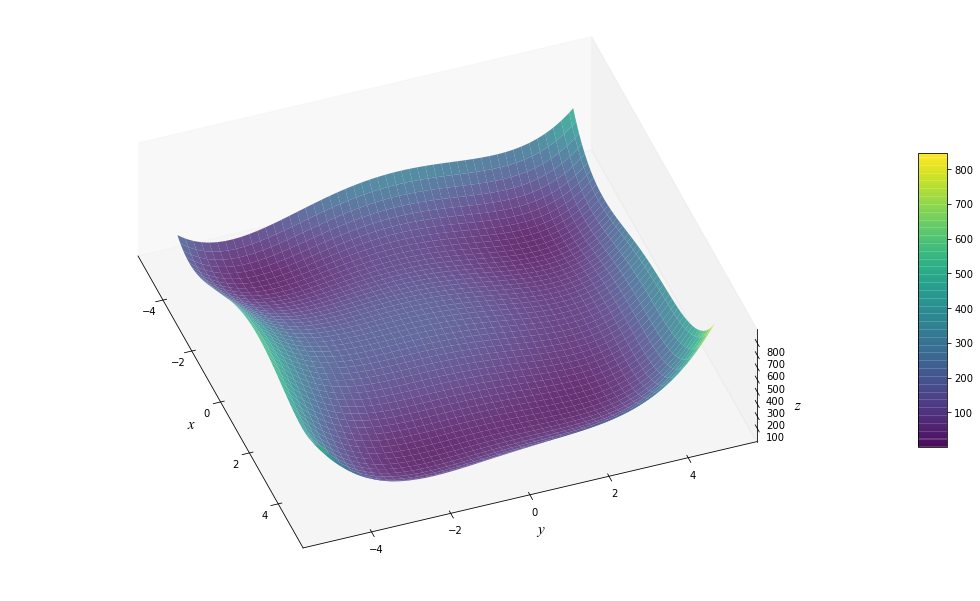

In [5]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
x, y = np.meshgrid(x, y)
gr = GradientDescent()
visualize(x, y, gr.function(x, y))

<h2>Stochastic gradient descent</h2>
<p>Firstly, let us start with the "classic" algorithm - stochastic gradient descent. The idea of this method is quite easy: we choose the initial point $(x, y)^{t}$, count our function gradient at this point $\nabla(f(x, y))$, and make a step to the opposite side of the gradient direction. Then new point coordinates $(x, y)^{t+1}$ are: 
    \begin{equation}
    (x, y)^{t+1} = (x, y)^{t} - \alpha\cdot\nabla(f(x, y))
    \end{equation}
    <br>Here $\alpha$ - learning rate. It is important to note that this formula works not only with the two coordinates, but with the $n$.</p>

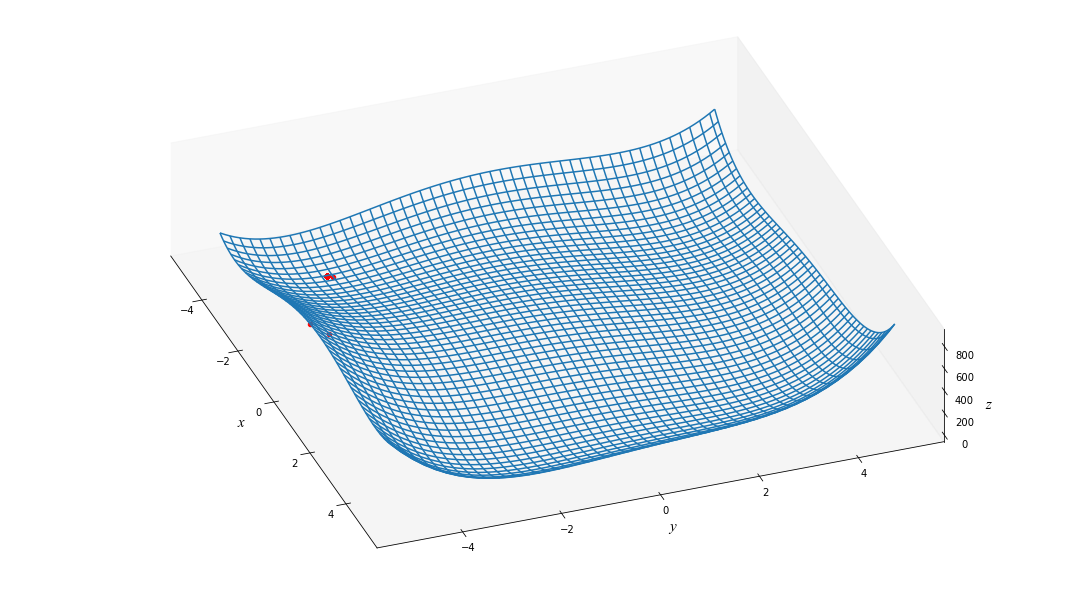

In [6]:
grad_history = gr.visualize_grad(method='Gradient descent')

<h2>Stochastic gradient descent with momentum</h2>
<p>Let us now consider the stochasctic gradient descent modification. In some situations when function we optimize is bad, stochastic gradient descent starts to converge badly, due to the situation of "rushing" gradient. And here is the solution: let us draw an analogy with the rolling ball and describe its motion: 
    \begin{equation}
    \begin{cases}
    \displaystyle \frac{\partial v}{\partial t} = \frac{1}{m}(F + F_{fr}) = -\frac{1}{m} \nabla f - \frac{1}{m} \eta v \\
    \displaystyle \frac{\partial x}{\partial t} = v
    \end{cases}
    \end{equation}
Then approximate derivatives using finite-difference equations:
    \begin{equation}
    \displaystyle \frac{\partial v}{\partial t} = \frac{v^{t+1} - v^{t}}{\Delta t}\\
    \displaystyle \frac{\partial x}{\partial t} = \frac{x^{t+1} - x^{t}}{\Delta t}
    \end{equation}
Substitute approximations to the system:
    \begin{equation}
    \begin{cases}
    \displaystyle v^{t+1} = v^{t} - \frac{\Delta t}{m} \nabla f - \frac{\Delta t}{m} \eta v^{t}\\
    \displaystyle x^{t+1} = x^{t} + v^{t} \cdot \Delta t
    \end{cases}
    \end{equation}
Then let us substitute the following variables:
    \begin{equation}
    \begin{cases}
    \displaystyle \Delta t = \alpha\\
    \displaystyle 1 - \frac{\Delta t}{m} \eta = \beta
    \end{cases}
    \end{equation}
Now let us set that \begin{equation} \frac{\Delta t}{m} = 1 \end{equation}, and we get:
    \begin{equation}
    \begin{cases}
    \displaystyle v^{t+1} = v^{t} \cdot \beta - \nabla f\\
    \displaystyle x^{t+1} = x^{t} + \alpha v^{t}
    \end{cases}
    \end{equation}
</p>

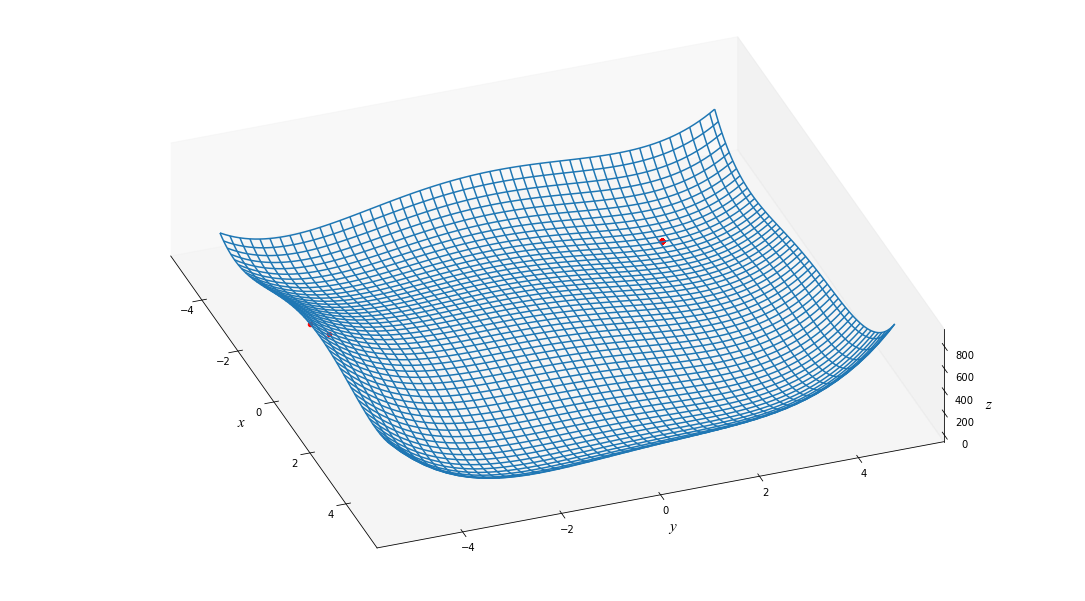

In [7]:
SGD_history = gr.visualize_grad(method='SGD')

<h2>Stochastic gradient descent with EMA</h2>
<p>One more algorithm of gradient descent exists:
    \begin{equation}
    x^{t+1} = x^{t} - \alpha EMA(\nabla f)^{t}
    \end{equation}
Here $EMA$ - exponential moving average:
    \begin{equation}
    EMA_{\beta}(f)^{t} = (1 - \beta)f^{t} + \beta \cdot EMA_{\beta}(f)^{t-1}
    \end{equation}
</p>

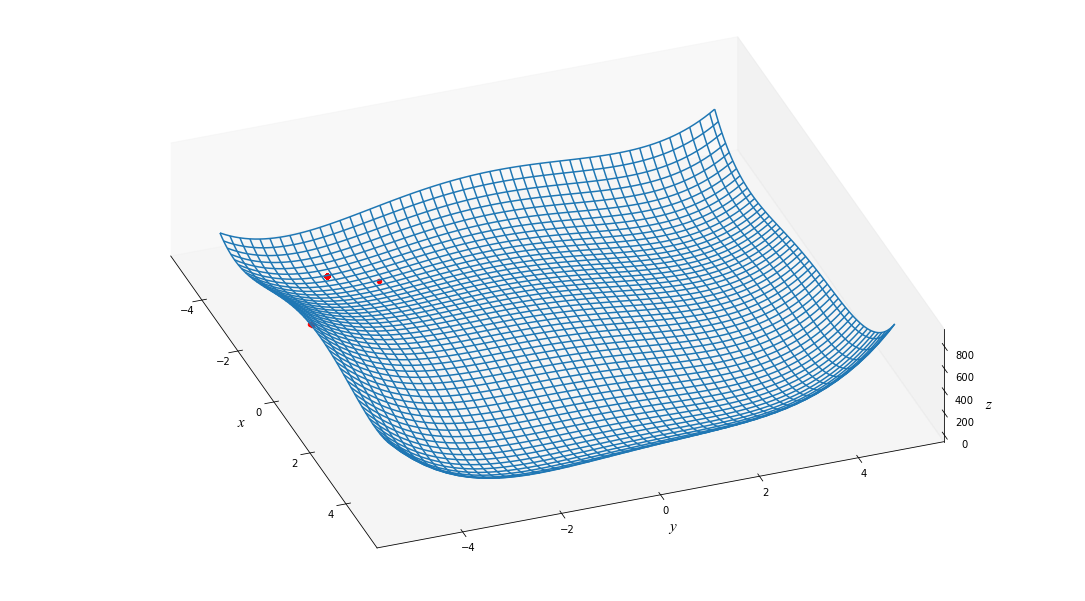

In [8]:
EMA_grad_history = gr.visualize_grad(method='EMA grad')

<h2>RMSprop</h2>
<p>RMSprop is a modification of RMprop. Unlike the RMprop RMSprop works with data batches:
    \begin{equation}
    x^{t+1} = x^{t} - \alpha \frac{\nabla f(x^{t})}{\sqrt{EMA_{\gamma}(\nabla f^{2})^{t}}}
    \end{equation}
Here is the idea of this algorithm: if the derivative on some direction is quite big less step is needed on this direction and vice versa. Thus, the learning velocity adjusts to each parameter.</p>

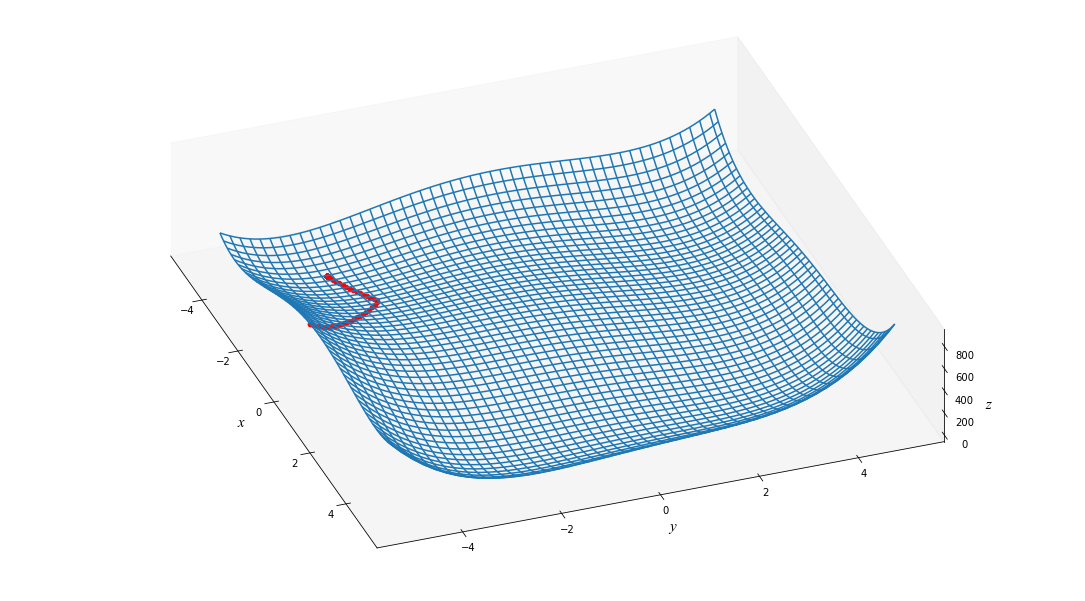

In [9]:
RMSprop_history = gr.visualize_grad(method='RMSprop')

<h2>ADAM</h2>
<p>The last and perhaps the best algorithm is ADAM (adaptive moment estimation). It is a modification of RMSprop and it looks like:
    \begin{equation}
    x^{t+1} = x^{t} - \alpha \frac{EMA_{\beta_{1}} (\nabla f)^{t}}{\sqrt{EMA_{\beta_{2}} (\nabla f^{2})^{t}} + \varepsilon}
    \end{equation}
Optimal parameters for ADAM: $\alpha = 3 \cdot 10^{-4}$, $\beta_{1} = 0.9$, $\beta_{2} = 0.999$</p>

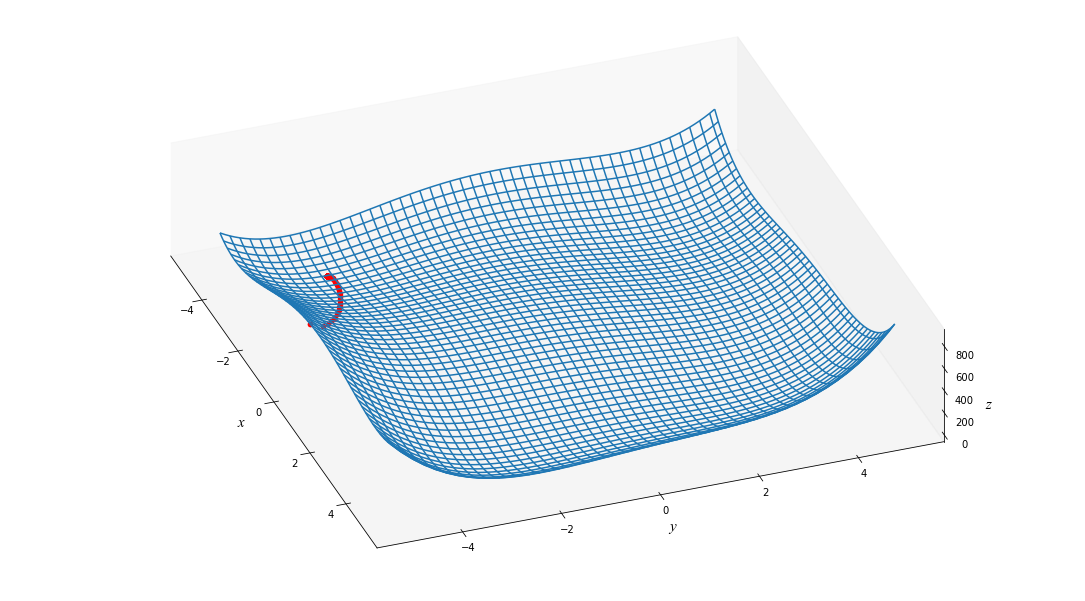

In [10]:
ADAM_history = gr.visualize_grad(method='ADAM')

<p>In cells above we got lists with the points that we get during performing each algorithm. Let us now draw a surface, lines and points for animation.</p>

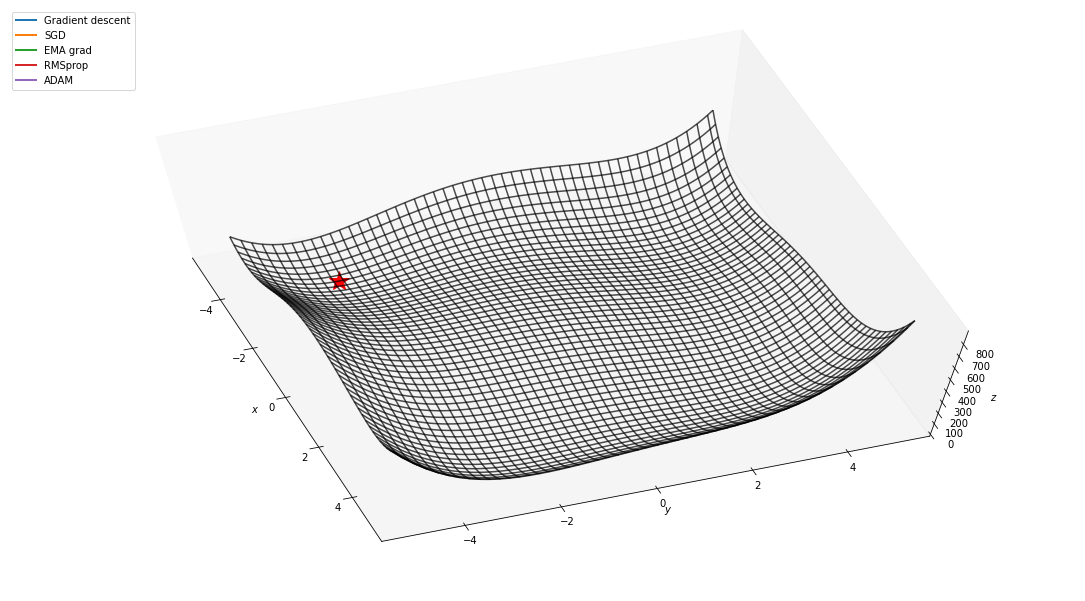

In [25]:
fig = plt.figure(figsize=(19.20, 10.80))
ax = plt.axes(projection='3d')

ax.plot_wireframe(x, y, gr.function(x, y), cmap=cm.jet, alpha=0.7, edgecolor=None)
ax.plot(*np.array(ADAM_history[-1]).reshape(-1, 1), gr.function(*np.array(ADAM_history[-1]).reshape(-1, 1)),\
        color='red', marker='*', markersize=20)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.view_init(70, -20)
ax.grid(False)

paths = [] # create a list for containing all the algorithms lists
path_grad = np.array(grad_history).T
path_SGD = np.array(SGD_history).T
path_EMA_grad = np.array(EMA_grad_history).T
path_RMSprop = np.array(RMSprop_history).T
path_ADAM = np.array(ADAM_history).T
paths.append(path_grad)
paths.append(path_SGD)
paths.append(path_EMA_grad)
paths.append(path_RMSprop)
paths.append(path_ADAM)
paths = np.array(paths)
zpath = [gr.function(*path) for path in paths] # count the function value at every point of lists

anim = TrajectoryAnimation3D(*paths, zpaths=zpath, labels=['Gradient descent', 'SGD', 'EMA grad', 'RMSprop', 'ADAM'], ax=ax)

ax.legend(loc='upper left')

<p>Animate algorithms.</p>

In [26]:
HTML(anim.to_html5_video())

<p>As a result we got animated performance of every algorithm. As we can see every algorithm finds the local minimum of this surface. This surface have four local minimums. SGD got high "velocity" and found the other minimum. It happens because of hyperparameters of the algorithm.<br> Functions values at every optimum is written below.<p>

In [24]:
print('''Minimum value of the function: {0} \nMinimum value using stochastic gradient descent: {1}
Minimum value using stochastic gradient descent with momentum: {2}\nMinimum value using EMA grad: {3}
Minimum value using RMSprop: {4}\nMinimum value using ADAM: {5}'''\
      .format(gr.function(x, y).min(), gr.function(*grad_history[-1]), gr.function(*SGD_history[-1])\
              , gr.function(*EMA_grad_history[-1]), gr.function(*RMSprop_history[-1]), gr.function(*ADAM_history[-1])))

Minimum value of the function: 0.00436989114706011 
Minimum value using stochastic gradient descent: 6.373996114185775e-28
Minimum value using stochastic gradient descent with momentum: 7.888609052210118e-31
Minimum value using EMA grad: 7.888609052210118e-29
Minimum value using RMSprop: 3.262449484062734e-05
Minimum value using ADAM: 1.4262605166395893e-27


<p>Cell for saving animation as mp4 video is written below.</p>

In [17]:
# anim.save('./anim.mp4')

<h4>Cell for notebook styling is written below.</h4>

In [18]:
with open('./style.css') as f:
    style = f.read()
HTML(style)